# PyTorch之迁移学习

实际中，基本没有人会从零开始（随机初始化）训练一个完整的卷积网络，因为相对于网络，很难得到一个足够大的数据集[网络很深, 需要足够大数据集]。通常的做法是在一个很大的数据集上进行预训练得到卷积网络ConvNet, 然后将这个ConvNet的参数作为目标任务的初始化参数或者固定这些参数。
## 转移学习的两个主要场景：

* 微调Convnet：使用预训练的网络(如在imagenet 1000上训练而来的网络)来初始化自己的网络，而不是随机初始化。其他的训练步骤不变。
* 将Convnet看成固定的特征提取器:首先固定ConvNet除了最后的全连接层外的其他所有层。最后的全连接层被替换成一个新的随机 初始化的层，只有这个新的层会被训练[只有这层参数会在反向传播时更新]

下面是利用PyTorch进行迁移学习步骤，要解决的问题是训练一个模型来对蚂蚁和蜜蜂进行分类。

## 1.导入相关的包

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 2.加载数据

今天要解决的问题是训练一个模型来分类蚂蚁ants和蜜蜂bees。ants和bees各有约120张训练图片。每个类有75张验证图片。从零开始在 如此小的数据集上进行训练通常是很难泛化的。由于我们使用迁移学习，模型的泛化能力会相当好。 该数据集是imagenet的一个非常小的子集。从此处下载数据，并将其解压缩到当前目录。

In [2]:
#训练集数据扩充和归一化
#在验证集上仅需要归一化
data_transform = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val":transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data/'
images_datasets = {x : datasets.ImageFolder(os.path.join(data_dir,x),
                                        data_transform[x]) 
                   for x in ['train','val']}
dataloader = {x : torch.utils.data.DataLoader(images_datasets[x],batch_size=4,
                                             shuffle=True,num_workers=0)
             for x in ['train','val']}
dataset_sizes = {x: len(images_datasets[x]) for x in ['train', 'val']}
class_names = images_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 3.可视化部分图像数据
可视化部分训练图像，以便了解数据扩充。

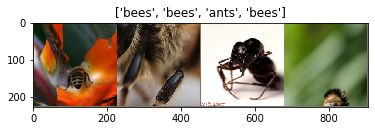

In [3]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 获取一批训练数据
inputs, classes = next(iter(dataloader['train']))

# 批量制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 4.训练模型

编写一个通用函数来训练模型。下面将说明：

* 调整学习速率
* 保存最好的模型

下面的参数scheduler是一个来自 torch.optim.lr_scheduler的学习速率调整类的对象(LR scheduler object)。

In [31]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 每个epoch都有一个训练和验证阶段
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # 迭代数据.
            for inputs, labels in dataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 零参数梯度
                optimizer.zero_grad()

                # 前向
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 后向+仅在训练阶段进行优化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 统计
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 深度复制mo
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model

## 5.可视化模型的预测结果

In [38]:
#一个通用的展示少量预测图片的函数
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 6.场景1：微调ConvNet
加载预训练模型并重置最终完全连接的图层。

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs,2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()


# 观察所有参数都正在优化
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 每7个epochs衰减LR通过设置gamma=0.1
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

训练和评估模型
（1）训练模型 该过程在CPU上需要大约15-25分钟，但是在GPU上，它只需不到一分钟。

In [32]:
model_ft = train_model(model_ft, criterion,optimizer_ft,exp_lr_scheduler,
                      num_epochs=25)

Epoch 0/24
----------
train Loss: 0.4768 Acc: 0.8238
val Loss: 0.4861 Acc: 0.8105

Epoch 1/24
----------
train Loss: 0.5283 Acc: 0.8074
val Loss: 0.3491 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.5180 Acc: 0.8033
val Loss: 0.4963 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.5120 Acc: 0.7910
val Loss: 0.4151 Acc: 0.8562

Epoch 4/24
----------
train Loss: 0.4755 Acc: 0.8402
val Loss: 0.2046 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.2691 Acc: 0.8852
val Loss: 0.1217 Acc: 0.9608

Epoch 6/24
----------
train Loss: 0.3884 Acc: 0.8279
val Loss: 0.1397 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3334 Acc: 0.8607
val Loss: 0.1353 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3534 Acc: 0.8525
val Loss: 0.1298 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3013 Acc: 0.8770
val Loss: 0.1521 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2624 Acc: 0.8811
val Loss: 0.1413 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3300 Acc: 0.8730
val Loss: 0.1364 Acc: 0.9346

Ep

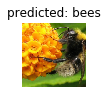

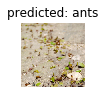

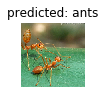

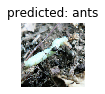

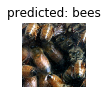

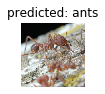

In [39]:
visualize_model(model_ft)

## 7.场景2：ConvNet作为固定特征提取器

在这里需要冻结除最后一层之外的所有网络。通过设置requires_grad == Falsebackward()来冻结参数，这样在反向传播backward()的时候他们的梯度就不会被计算。

In [40]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

训练和评估

（1）训练模型 在CPU上，与前一个场景相比，这将花费大约一半的时间，因为不需要为大多数网络计算梯度。但需要计算转发。

In [42]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.3464 Acc: 0.8361
val Loss: 0.1895 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.3189 Acc: 0.8689
val Loss: 0.1894 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3349 Acc: 0.8443
val Loss: 0.1931 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3586 Acc: 0.8525
val Loss: 0.2194 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3706 Acc: 0.8525
val Loss: 0.1883 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.3736 Acc: 0.8525
val Loss: 0.1729 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.4371 Acc: 0.7787
val Loss: 0.2028 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3221 Acc: 0.8689
val Loss: 0.1986 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3584 Acc: 0.8156
val Loss: 0.2013 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3146 Acc: 0.8648
val Loss: 0.2106 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4041 Acc: 0.8566
val Loss: 0.2037 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.2640 Acc: 0.9016
val Loss: 0.1918 Acc: 0.9412

Ep

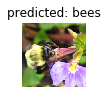

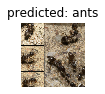

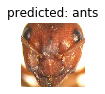

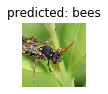

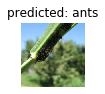

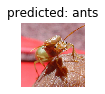

In [43]:
visualize_model(model_conv)

plt.ioff()
plt.show()